In [1]:
import torch as th
from time import time
from params import default_params, set_tsp_params

# ------------------------- SET DEFAULT DEVICE -------------------
params = default_params()
#print("Device in use: ", params['device'])
#if params['device'] == 'cuda':
#    print("Setting cuda buy default")
#    th.set_default_device('cuda')
#    th.set_default_tensor_type('torch.cuda.FloatTensor')
#else:
#    print("Cuda not available setting cpu by default")
#    th.set_default_device('cpu')
#    th.set_default_tensor_type('torch.FloatTensor')
# ----------------------------------------------------------------
th.set_default_device('cpu')
import optuna

from environments.environment_tsp import EnviornmentTSP
from networks.basic_network import BasicNetwork
from networks.more_basic_net import MoreBasicNetwork

from experiments.actor_critic_experiment import ActorCriticExperiment

# ------------------------- CONTROLLERS ----------------------------
from controllers.ac_controller import ActorCriticController
from controllers.epsilon_greedy_controller import EpsilonGreedyController
# ------------------------------------------------------------------

# ------------------------- LEARNERS --------------------------------
from learners.reinforce_learner import ReinforceLearner
from learners.biased_reinforce_learner import BiasedReinforceLearner
from learners.actor_critic_learner import ActorCriticLearner
from learners.off_policy_actor_critic_learner import OffpolicyActorCriticLearner
from learners.ppo_learner import PPOLearner
# ------------------------------------------------------------------

from generators.tsp_generator import TSPGenerator
from exact_solvers.solver_tsp import solve_tsp

In [2]:
max_nodes_per_graph = 10
rollouts_per_batch = 50
pct_epsilon_anneal_time = 0.75
max_episodes = 750

params['problem'] = 'tsp'
params['node_dimension'] = 2
params['max_nodes_per_graph'] = max_nodes_per_graph
params['max_episode_length'] = max_nodes_per_graph + 1
params['max_episodes'] = max_episodes
params['batch_size'] = params['max_episode_length'] * rollouts_per_batch
params['max_steps'] = params['max_episodes'] * params['max_episode_length'] * rollouts_per_batch
params['epsilon_start'] = 1.0
params['epsilon_finish'] = 1E-5
params['epsilon_anneal_time'] =  pct_epsilon_anneal_time * params['max_steps']
params['lr'] = 5E-4
params['gamma'] = 0.99
params['entropy_regularization'] = True
params['entropy_weight'] = 0.1
params['plot_frequency'] = 10
params['multi_runner'] = False               
params['parallel_environments'] = 4     
params['epsilon_decay'] = "exponential"
print("Epsilon anneal time: ", params['epsilon_anneal_time'])

Epsilon anneal time:  309375.0


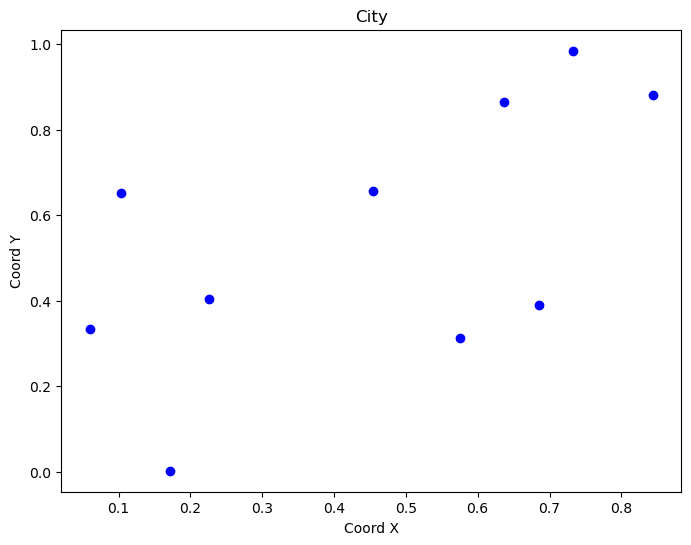

In [3]:
nodes_per_graph = 10
instance = 0
cities = th.load(f"training/tsp/size_{nodes_per_graph}/instance_{instance}.pt")
#cities = cities.to(params['device'])
tsp_generator = TSPGenerator()
tsp_generator.plot_instance(cities)

In [4]:
permutation, distance = solve_tsp(cities)
print(f"Permutation: {permutation}\nDistance: {distance}")

Permutation: [0, 5, 3, 8, 7, 4, 6, 9, 1, 2]
Distance: 2.9008774757385254


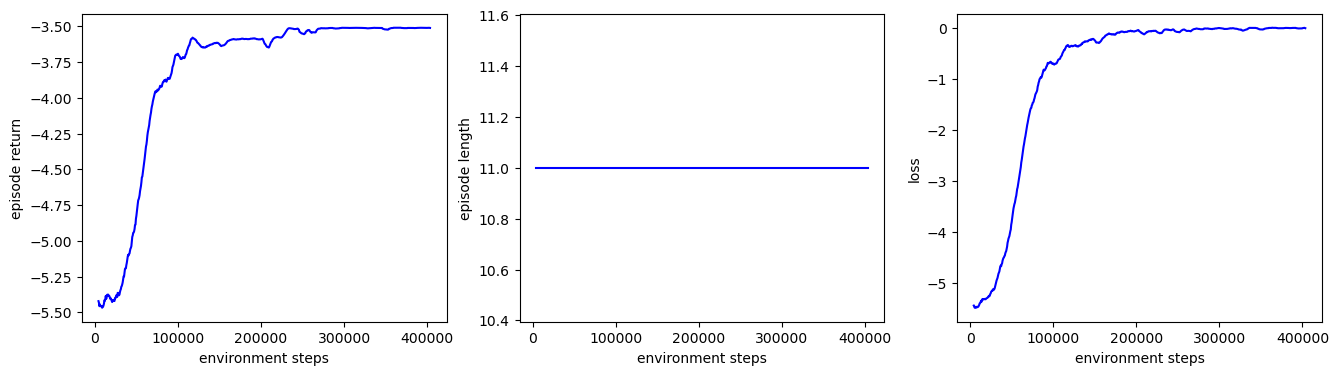

Total spended time in experiment:  571.1586716175079


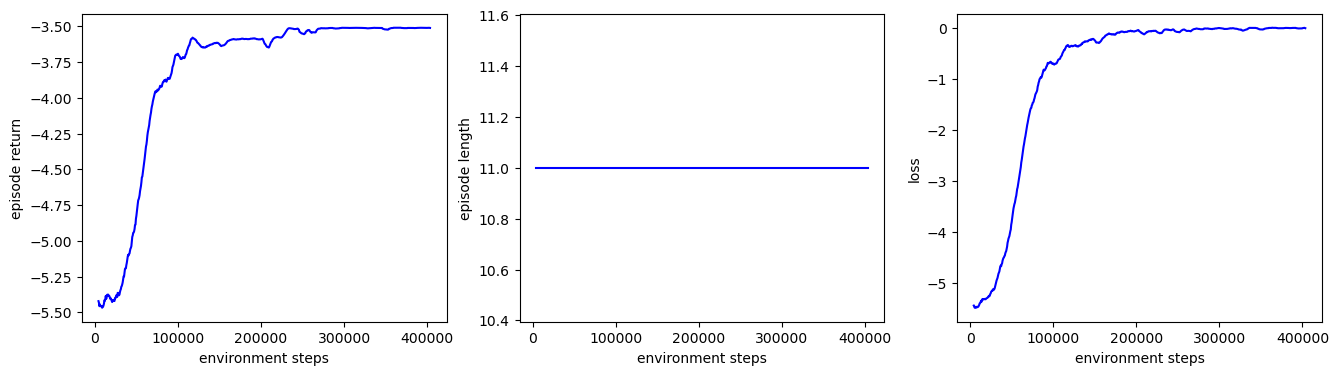

In [5]:
model = MoreBasicNetwork(params)
env = EnviornmentTSP(cities, params=params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, ReinforceLearner(model, params))
start = time()
experiment.run()
end = time()
total_time = end - start
print("Total spended time in experiment: ", total_time)

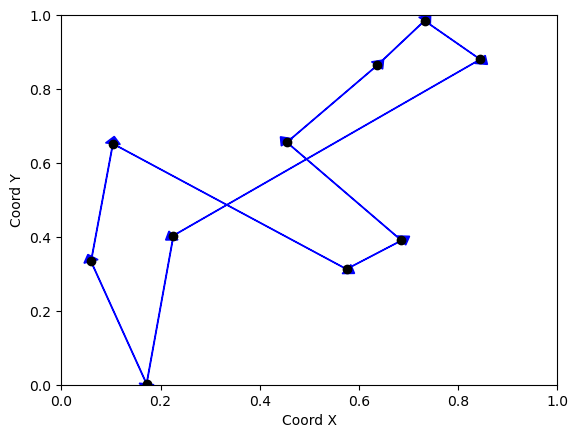

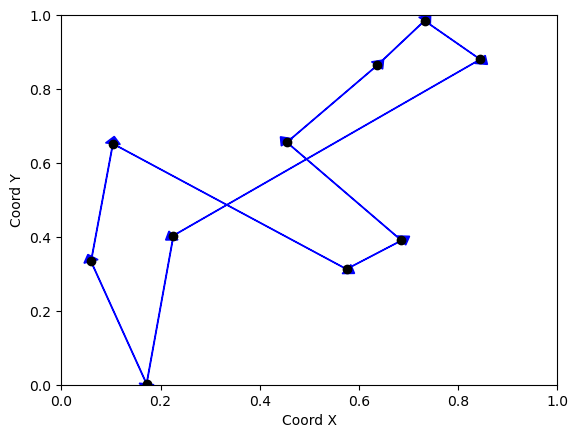

In [6]:
experiment.plot_rollout()

In [7]:
params['advantage_bias'] = True
params['value_targets'] = 'td'

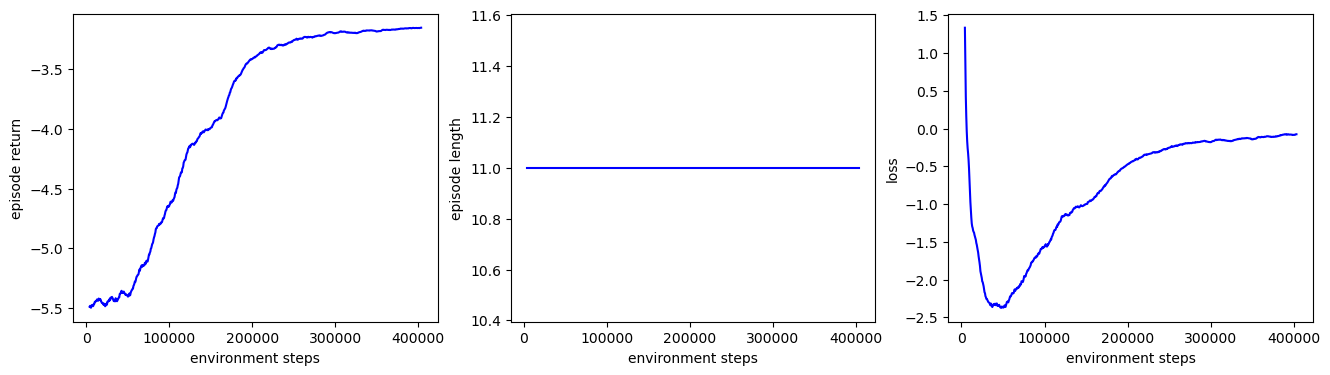

Total spended time in experiment:  741.5621502399445


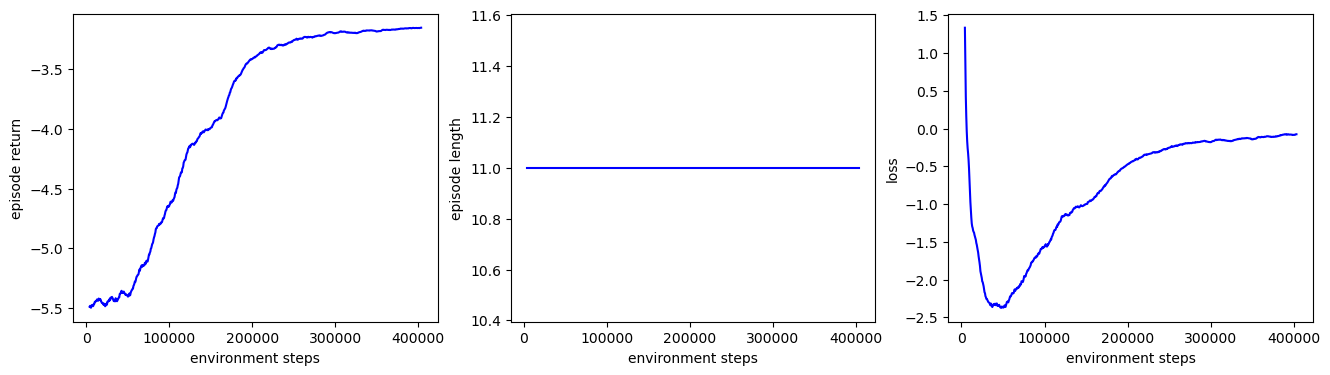

In [9]:
model = MoreBasicNetwork(params)
env = EnviornmentTSP(cities, params=params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, BiasedReinforceLearner(model, params))
start = time()
experiment.run()
end = time()
total_time = end - start
print("Total spended time in experiment: ", total_time)

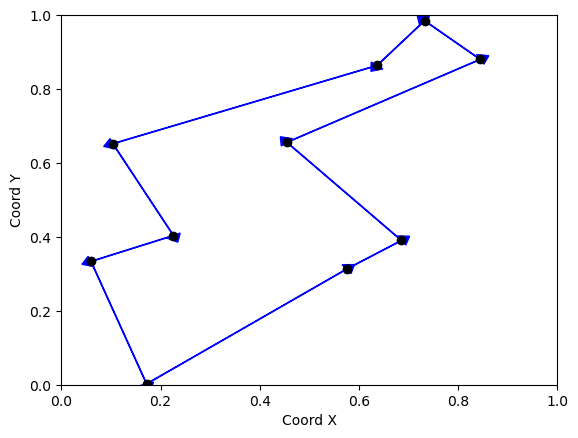

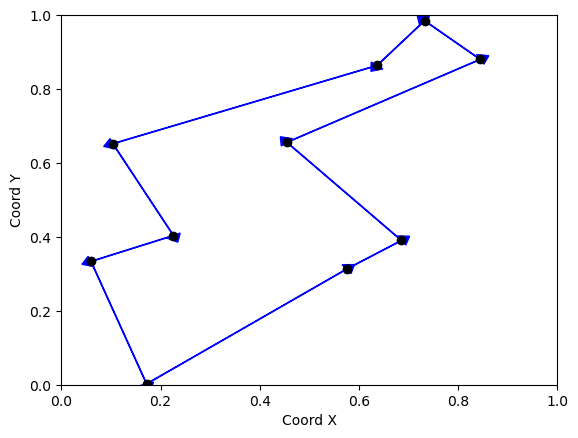

In [10]:
experiment.plot_rollout()

In [11]:
params['advantage_bootstrap'] = True

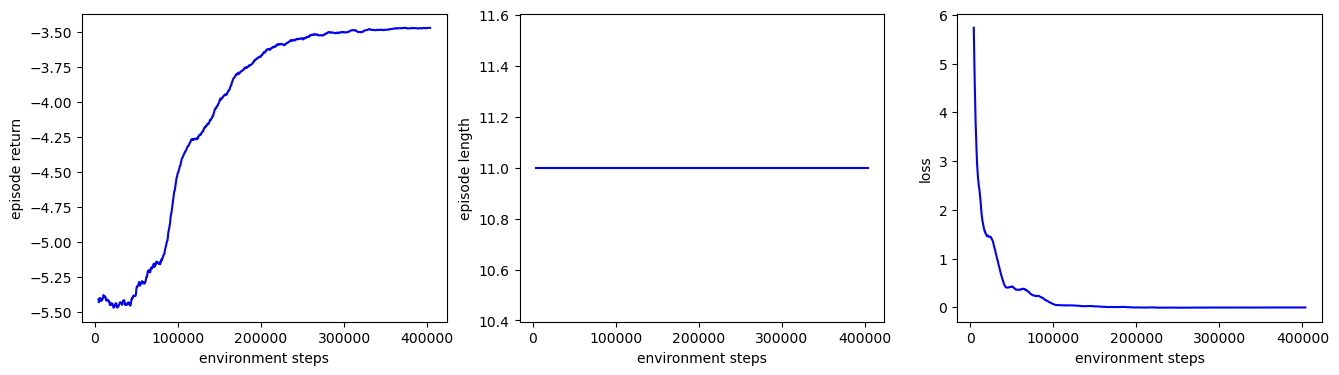

Total spended time in experiment:  753.0173554420471


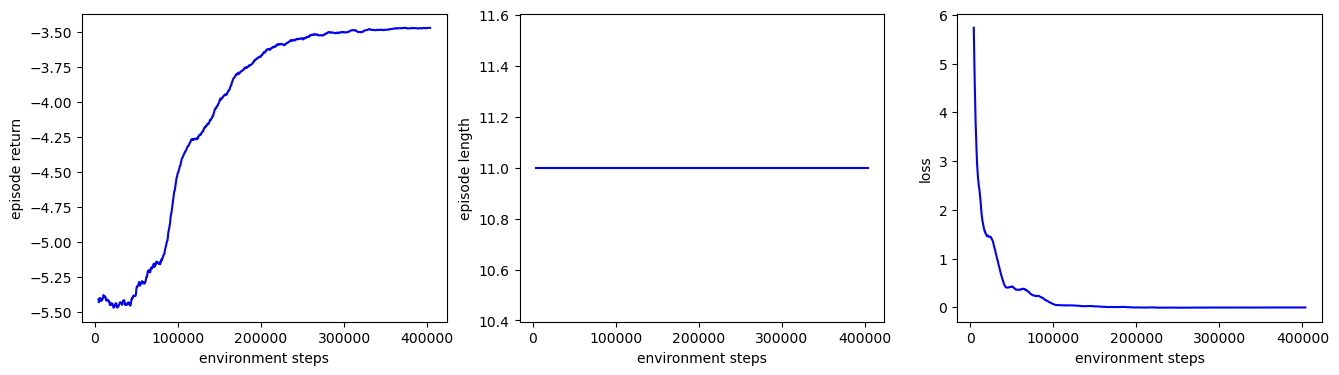

In [12]:
model = MoreBasicNetwork(params)
env = EnviornmentTSP(cities, params=params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, ActorCriticLearner(model, params))
start = time()
experiment.run()
end = time()
total_time = end - start
print("Total spended time in experiment: ", total_time)

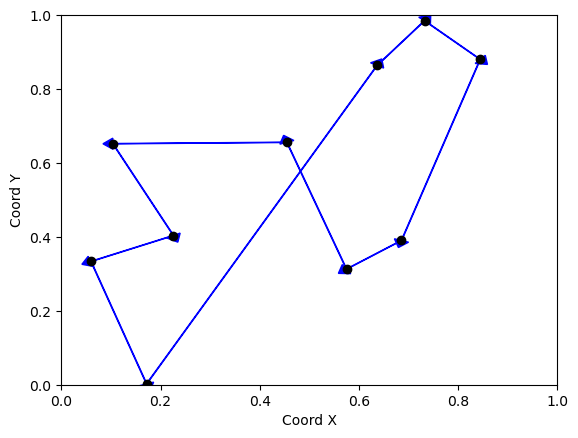

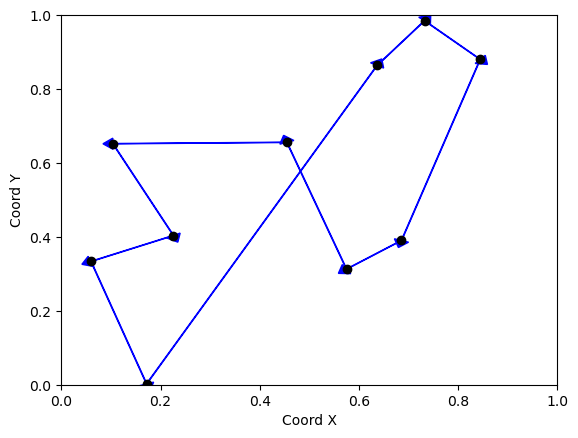

In [13]:
experiment.plot_rollout()

In [14]:
params['offpolicy_iterations'] = 50

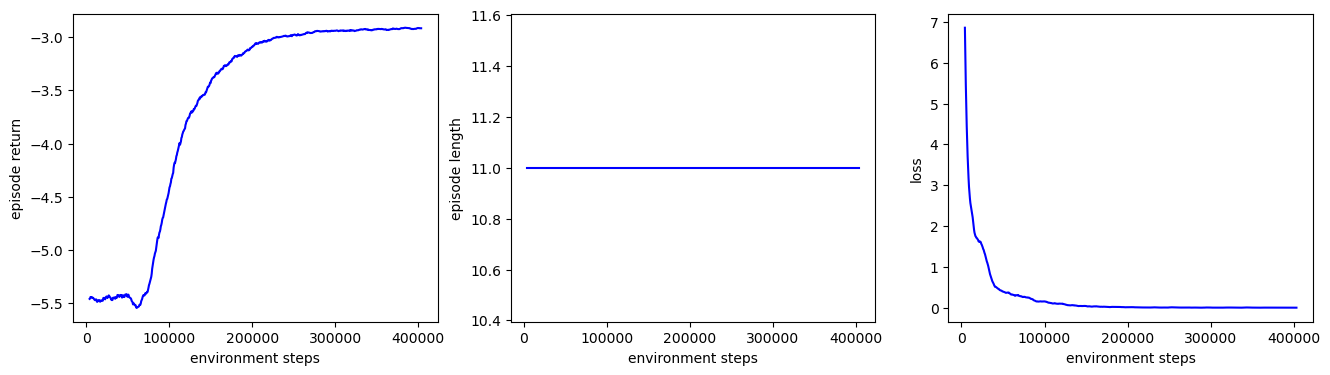

Total spended time in experiment:  756.8950886726379


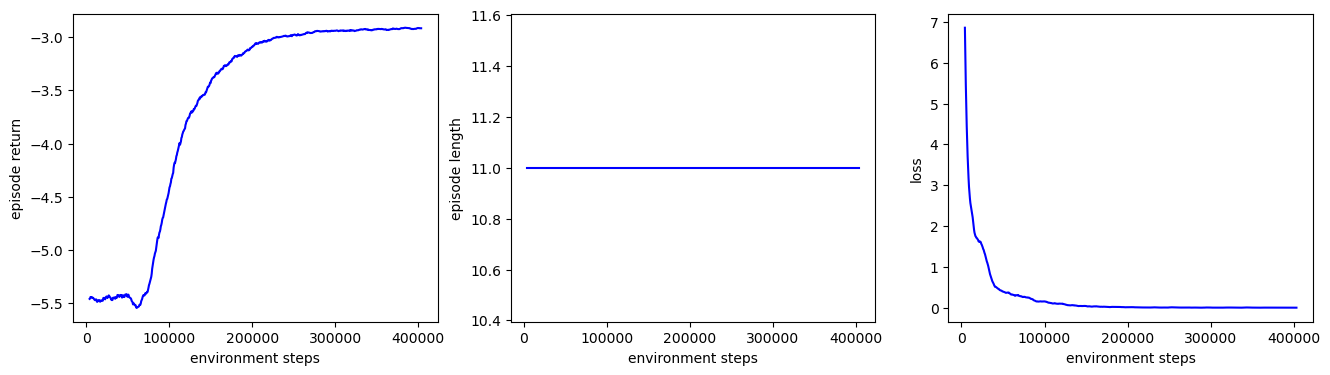

In [15]:
model = MoreBasicNetwork(params)
env = EnviornmentTSP(cities, params=params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, OffpolicyActorCriticLearner(model, params))
start = time()
experiment.run()
end = time()
total_time = end - start
print("Total spended time in experiment: ", total_time)

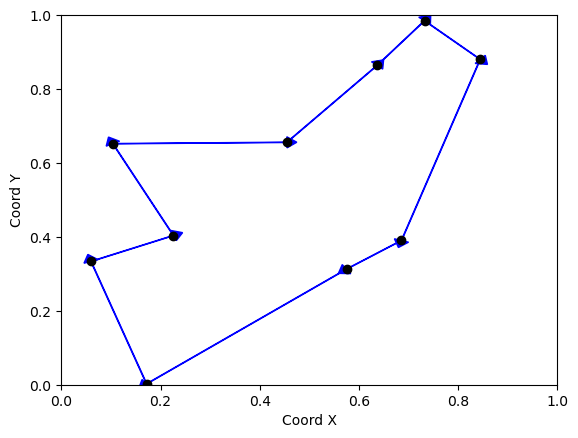

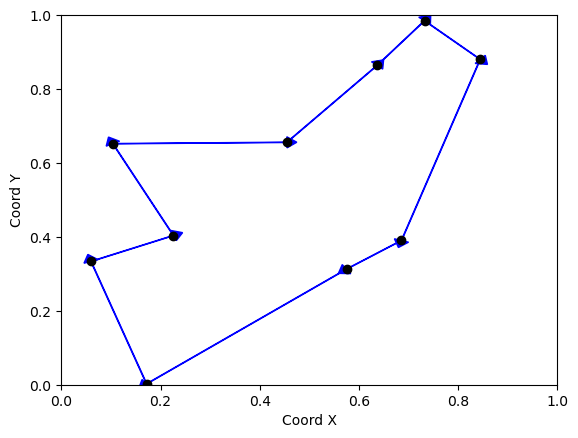

In [16]:
experiment.plot_rollout()

In [17]:
params['ppo_clipping'] = True
params['ppo_clip_eps'] = 0.1

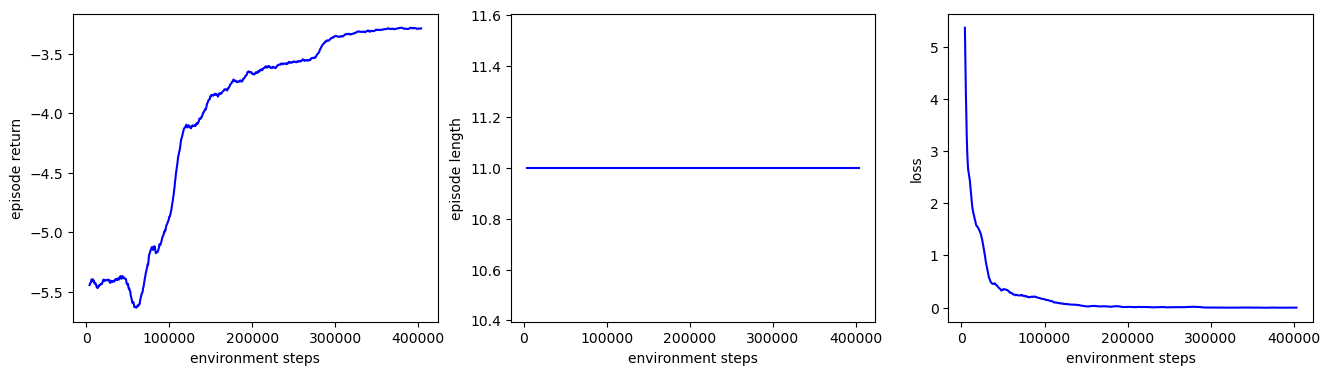

Total spended time in experiment:  842.8754363059998


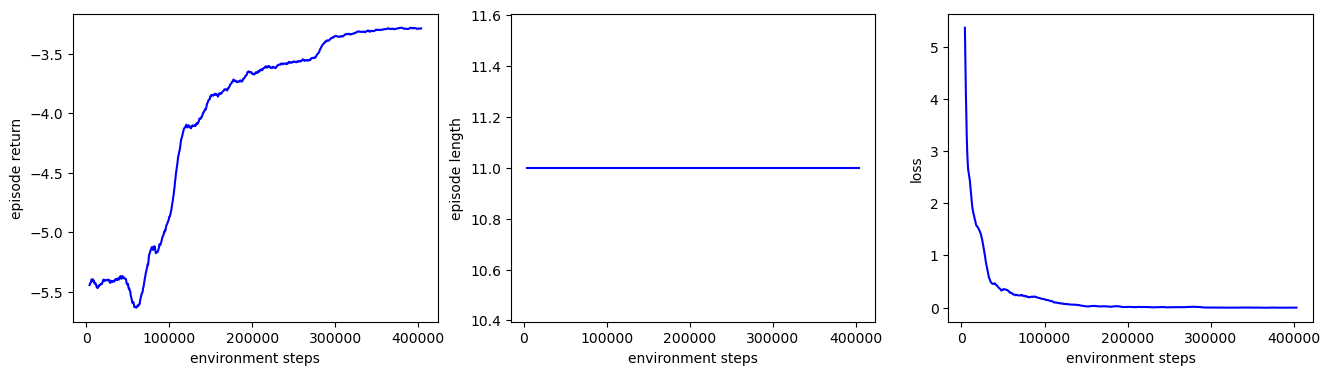

In [18]:
model = MoreBasicNetwork(params)
env = EnviornmentTSP(cities, params=params)

# Run experiment
experiment = ActorCriticExperiment(params, model, env, PPOLearner(model, params))
start = time()
experiment.run()
end = time()
total_time = end - start
print("Total spended time in experiment: ", total_time)

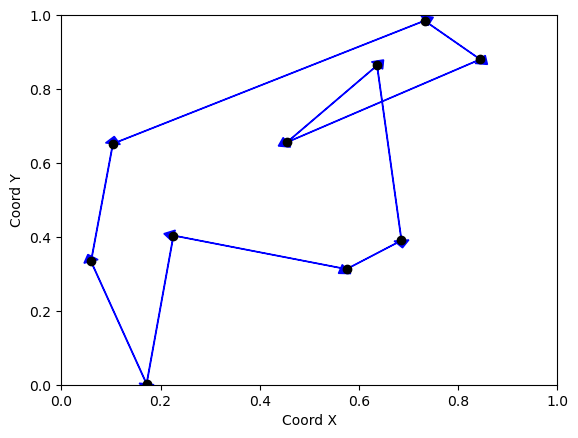

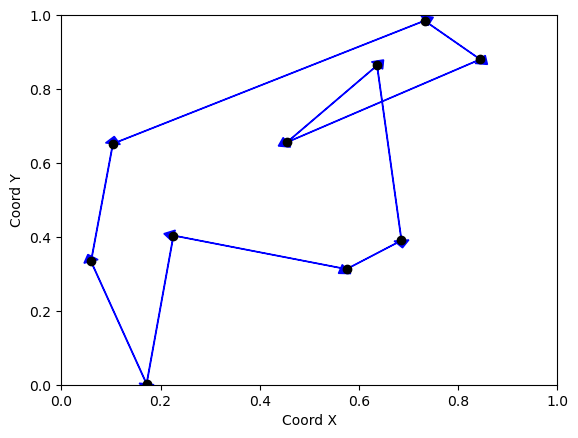

In [19]:
experiment.plot_rollout()

In [ ]:
def objective(trial):
    # Define the hyperparameters as trial suggestions
    lr = trial.suggest_float('lr', 1e-6, 1e-1, log=True)
    pct_epsilon_anneal_time = trial.suggest_float('pct_epsilon_anneal_time', 0.3, 0.8)
    epsilon_start = trial.suggest_float('epsilon_start', 0.5, 1)
    epsilon_finish = trial.suggest_float('epsilon_finish', 0.00001, 0.5)

    # Use these parameters to create components
    params['epsilon_start'] = epsilon_start
    params['epsilon_finish'] = epsilon_finish
    params['epsilon_anneal_time'] = pct_epsilon_anneal_time * params['max_steps']
    params['lr'] = lr
    params['plot_frequency'] = None


    model = MoreBasicNetwork(params)
    env = EnviornmentTSP(cities, params)
    experiment = ActorCriticExperiment(params, model, env, ReinforceLearner(model, params))

    # Perform training and return the evaluation metric
    final_metric = experiment.run()  # Assume `run` returns a performance indicator
    return final_metric

study = optuna.create_study(direction='maximize')  # or 'minimize' if you're minimizing a metric
study.optimize(objective, n_trials=25)  # You can adjust the number of trials